# Method 9 - Best Ideas Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

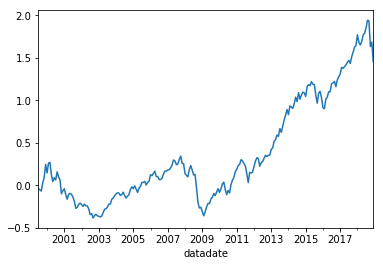

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.247699
2000-12-31   -0.247804
2001-12-31   -0.155660
2002-12-31   -0.188039
2003-12-31    0.363530
2004-12-31    0.121692
2005-12-31    0.066397
2006-12-31    0.114153
2007-12-31    0.074164
2008-12-31   -0.407390
2009-12-31    0.293112
2010-12-31    0.208013
2011-12-31   -0.005289
2012-12-31    0.173452
2013-12-31    0.394429
2014-12-31    0.103564
2015-12-31   -0.028022
2016-12-31    0.122597
2017-12-31    0.161474
2018-12-31   -0.073224
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     676.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.67e-125
Time:                        20:15:40   Log-Likelihood:                 681.70
No. Observations:                 234   AIC:                            -1353.
Df Residuals:                     229   BIC:                            -1336.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.222      0.825      -0.002       0.002
mktrf          1.0078      0.025     40.686      0.000       0.959       1.057
me             0.2447      0.029      8.492      0.000       0.188       0.301
ia            -0.2072      0.044     -4.732      0.000      -0.294      -0.121
roe            0.1654      0.037      4.413      0.000       0.092       0.239
==============================================================================
Omnibus:                       26.334   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.561
Skew:                          -0.126   Prob(JB):                     1.21e-28
Kurtosis:                       6.623   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     261.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.74e-84
Time:                        20:15:40   Log-Likelihood:                 681.70
No. Observations:                 234   AIC:                            -1353.
Df Residuals:                     229   BIC:                            -1336.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.267      0.789      -0.002       0.001
mktrf          1.0078      0.033     30.330      0.000       0.943       1.073
me             0.2447      0.029      8.377      0.000       0.187       0.302
ia            -0.2072      0.077     -2.676      0.007      -0.359      -0.055
roe            0.1654      0.049      3.391      0.001       0.070       0.261
==============================================================================
Omnibus:                       26.334   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.561
Skew:                          -0.126   Prob(JB):                     1.21e-28
Kurtosis:                       6.623   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     276.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.92e-86
Time:                        20:15:40   Log-Likelihood:                 681.70
No. Observations:                 234   AIC:                            -1353.
Df Residuals:                     229   BIC:                            -1336.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.288      0.773      -0.002       0.001
mktrf          1.0078      0.032     31.214      0.000       0.945       1.071
me             0.2447      0.029      8.478      0.000       0.188       0.301
ia            -0.2072      0.075     -2.746      0.006      -0.355      -0.059
roe            0.1654      0.049      3.407      0.001       0.070       0.261
==============================================================================
Omnibus:                       26.334   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.561
Skew:                          -0.126   Prob(JB):                     1.21e-28
Kurtosis:                       6.623   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     472.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.00e-118
Time:                        20:15:40   Log-Likelihood:                 667.66
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.239      0.812      -0.002       0.002
mktrf          0.9780      0.026     37.026      0.000       0.926       1.030
smb            0.2520      0.035      7.230      0.000       0.183       0.321
hml           -0.1220      0.041     -2.968      0.003      -0.203      -0.041
rmw            0.0729      0.046      1.569      0.118      -0.019       0.164
cma           -0.0701      0.059     -1.186      0.237      -0.186       0.046
==============================================================================
Omnibus:                       16.510   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.683
Skew:                           0.109   Prob(JB):                     2.68e-11
Kurtosis:                       5.224   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     302.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-98
Time:                        20:15:40   Log-Likelihood:                 667.66
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.261      0.794      -0.002       0.002
mktrf          0.9780      0.037     26.491      0.000       0.906       1.050
smb            0.2520      0.047      5.360      0.000       0.160       0.344
hml           -0.1220      0.073     -1.680      0.093      -0.264       0.020
rmw            0.0729      0.070      1.040      0.298      -0.064       0.210
cma           -0.0701      0.112     -0.626      0.532      -0.290       0.149
==============================================================================
Omnibus:                       16.510   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.683
Skew:                           0.109   Prob(JB):                     2.68e-11
Kurtosis:                       5.224   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     323.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.11e-101
Time:                        20:15:40   Log-Likelihood:                 667.66
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.277      0.782      -0.001       0.002
mktrf          0.9780      0.039     24.918      0.000       0.901       1.055
smb            0.2520      0.047      5.342      0.000       0.160       0.344
hml           -0.1220      0.078     -1.561      0.119      -0.275       0.031
rmw            0.0729      0.074      0.990      0.322      -0.071       0.217
cma           -0.0701      0.108     -0.651      0.515      -0.281       0.141
==============================================================================
Omnibus:                       16.510   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.683
Skew:                           0.109   Prob(JB):                     2.68e-11
Kurtosis:                       5.224   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     795.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.34e-133
Time:                        20:15:40   Log-Likelihood:                 699.35
No. Observations:                 234   AIC:                            -1389.
Df Residuals:                     229   BIC:                            -1371.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.566      0.572      -0.002       0.001
mktrf          1.0479      0.021     49.548      0.000       1.006       1.090
smb            0.1516      0.026      5.743      0.000       0.100       0.204
hml           -0.0478      0.026     -1.822      0.070      -0.099       0.004
umd            0.1551      0.017      9.011      0.000       0.121       0.189
==============================================================================
Omnibus:                       28.668   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.627
Skew:                          -0.494   Prob(JB):                     3.11e-18
Kurtosis:                       5.701   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     720.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.99e-128
Time:                        20:15:40   Log-Likelihood:                 699.35
No. Observations:                 234   AIC:                            -1389.
Df Residuals:                     229   BIC:                            -1371.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.652      0.514      -0.002       0.001
mktrf          1.0479      0.037     28.710      0.000       0.976       1.119
smb            0.1516      0.042      3.621      0.000       0.070       0.234
hml           -0.0478      0.039     -1.236      0.216      -0.124       0.028
umd            0.1551      0.032      4.852      0.000       0.092       0.218
==============================================================================
Omnibus:                       28.668   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.627
Skew:                          -0.494   Prob(JB):                     3.11e-18
Kurtosis:                       5.701   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     791.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.37e-133
Time:                        20:15:40   Log-Likelihood:                 699.35
No. Observations:                 234   AIC:                            -1389.
Df Residuals:                     229   BIC:                            -1371.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.738      0.460      -0.002       0.001
mktrf          1.0479      0.039     26.689      0.000       0.971       1.125
smb            0.1516      0.046      3.318      0.001       0.062       0.241
hml           -0.0478      0.040     -1.192      0.233      -0.126       0.031
umd            0.1551      0.030      5.212      0.000       0.097       0.213
==============================================================================
Omnibus:                       28.668   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.627
Skew:                          -0.494   Prob(JB):                     3.11e-18
Kurtosis:                       5.701   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     275.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.11e-58
Time:                        20:15:40   Log-Likelihood:                 323.91
No. Observations:                 120   AIC:                            -637.8
Df Residuals:                     115   BIC:                            -623.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.548      0.585      -0.004       0.002
mktrf          1.0346      0.043     24.144      0.000       0.950       1.119
me             0.2688      0.042      6.351      0.000       0.185       0.353
ia            -0.2735      0.066     -4.126      0.000      -0.405      -0.142
roe            0.2417      0.059      4.121      0.000       0.126       0.358
==============================================================================
Omnibus:                       10.045   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               24.310
Skew:                          -0.062   Prob(JB):                     5.26e-06
Kurtosis:                       5.202   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     105.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-37
Time:                        20:15:40   Log-Likelihood:                 323.91
No. Observations:                 120   AIC:                            -637.8
Df Residuals:                     115   BIC:                            -623.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.703      0.482      -0.003       0.002
mktrf          1.0346      0.057     18.101      0.000       0.923       1.147
me             0.2688      0.037      7.360      0.000       0.197       0.340
ia            -0.2735      0.103     -2.644      0.008      -0.476      -0.071
roe            0.2417      0.063      3.832      0.000       0.118       0.365
==============================================================================
Omnibus:                       10.045   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               24.310
Skew:                          -0.062   Prob(JB):                     5.26e-06
Kurtosis:                       5.202   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     102.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.14e-37
Time:                        20:15:40   Log-Likelihood:                 323.91
No. Observations:                 120   AIC:                            -637.8
Df Residuals:                     115   BIC:                            -623.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.797      0.425      -0.003       0.001
mktrf          1.0346      0.053     19.662      0.000       0.931       1.138
me             0.2688      0.035      7.611      0.000       0.200       0.338
ia            -0.2735      0.101     -2.704      0.007      -0.472      -0.075
roe            0.2417      0.052      4.643      0.000       0.140       0.344
==============================================================================
Omnibus:                       10.045   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               24.310
Skew:                          -0.062   Prob(JB):                     5.26e-06
Kurtosis:                       5.202   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.23e-52
Time:                        20:15:40   Log-Likelihood:                 313.19
No. Observations:                 120   AIC:                            -614.4
Df Residuals:                     114   BIC:                            -597.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.155      0.877      -0.003       0.004
mktrf          0.9993      0.050     20.139      0.000       0.901       1.098
smb            0.2836      0.056      5.046      0.000       0.172       0.395
hml           -0.1796      0.069     -2.608      0.010      -0.316      -0.043
rmw            0.1513      0.081      1.864      0.065      -0.010       0.312
cma           -0.0696      0.089     -0.782      0.436      -0.246       0.107
==============================================================================
Omnibus:                        2.781   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.644
Skew:                           0.098   Prob(JB):                        0.267
Kurtosis:                       3.700   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     119.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-43
Time:                        20:15:40   Log-Likelihood:                 313.19
No. Observations:                 120   AIC:                            -614.4
Df Residuals:                     114   BIC:                            -597.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.172      0.863      -0.003       0.003
mktrf          0.9993      0.068     14.763      0.000       0.867       1.132
smb            0.2836      0.067      4.230      0.000       0.152       0.415
hml           -0.1796      0.111     -1.614      0.106      -0.398       0.038
rmw            0.1513      0.117      1.294      0.196      -0.078       0.381
cma           -0.0696      0.142     -0.492      0.623      -0.347       0.208
==============================================================================
Omnibus:                        2.781   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.644
Skew:                           0.098   Prob(JB):                        0.267
Kurtosis:                       3.700   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     110.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.42e-42
Time:                        20:15:40   Log-Likelihood:                 313.19
No. Observations:                 120   AIC:                            -614.4
Df Residuals:                     114   BIC:                            -597.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.174      0.862      -0.003       0.003
mktrf          0.9993      0.072     13.947      0.000       0.859       1.140
smb            0.2836      0.066      4.322      0.000       0.155       0.412
hml           -0.1796      0.122     -1.474      0.141      -0.419       0.059
rmw            0.1513      0.123      1.231      0.218      -0.090       0.392
cma           -0.0696      0.137     -0.506      0.613      -0.339       0.200
==============================================================================
Omnibus:                        2.781   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.644
Skew:                           0.098   Prob(JB):                        0.267
Kurtosis:                       3.700   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     350.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-63
Time:                        20:15:40   Log-Likelihood:                 337.29
No. Observations:                 120   AIC:                            -664.6
Df Residuals:                     115   BIC:                            -650.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.381      0.704      -0.002       0.003
mktrf          1.0966      0.034     32.477      0.000       1.030       1.164
smb            0.1092      0.038      2.840      0.005       0.033       0.185
hml           -0.0664      0.039     -1.725      0.087      -0.143       0.010
umd            0.1950      0.024      8.213      0.000       0.148       0.242
==============================================================================
Omnibus:                       19.234   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.865
Skew:                          -0.707   Prob(JB):                     4.43e-08
Kurtosis:                       5.185   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     356.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.73e-64
Time:                        20:15:40   Log-Likelihood:                 337.29
No. Observations:                 120   AIC:                            -664.6
Df Residuals:                     115   BIC:                            -650.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.477      0.633      -0.002       0.003
mktrf          1.0966      0.046     23.934      0.000       1.007       1.186
smb            0.1092      0.051      2.154      0.031       0.010       0.209
hml           -0.0664      0.047     -1.400      0.161      -0.159       0.027
umd            0.1950      0.038      5.147      0.000       0.121       0.269
==============================================================================
Omnibus:                       19.234   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.865
Skew:                          -0.707   Prob(JB):                     4.43e-08
Kurtosis:                       5.185   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     418.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-67
Time:                        20:15:40   Log-Likelihood:                 337.29
No. Observations:                 120   AIC:                            -664.6
Df Residuals:                     115   BIC:                            -650.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.539      0.590      -0.001       0.002
mktrf          1.0966      0.046     23.684      0.000       1.006       1.187
smb            0.1092      0.054      2.026      0.043       0.004       0.215
hml           -0.0664      0.047     -1.421      0.155      -0.158       0.025
umd            0.1950      0.031      6.393      0.000       0.135       0.255
==============================================================================
Omnibus:                       19.234   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.865
Skew:                          -0.707   Prob(JB):                     4.43e-08
Kurtosis:                       5.185   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     671.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.61e-76
Time:                        20:15:40   Log-Likelihood:                 392.80
No. Observations:                 114   AIC:                            -775.6
Df Residuals:                     109   BIC:                            -761.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.864      0.389      -0.001       0.002
mktrf          0.9852      0.023     42.469      0.000       0.939       1.031
me             0.1941      0.036      5.421      0.000       0.123       0.265
ia            -0.0789      0.050     -1.589      0.115      -0.177       0.020
roe            0.0238      0.044      0.545      0.587      -0.063       0.110
==============================================================================
Omnibus:                        0.548   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.686
Skew:                           0.079   Prob(JB):                        0.710
Kurtosis:                       2.655   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1092.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.18e-87
Time:                        20:15:40   Log-Likelihood:                 392.80
No. Observations:                 114   AIC:                            -775.6
Df Residuals:                     109   BIC:                            -761.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.975      0.330      -0.001       0.002
mktrf          0.9852      0.020     48.175      0.000       0.945       1.025
me             0.1941      0.036      5.436      0.000       0.124       0.264
ia            -0.0789      0.053     -1.483      0.138      -0.183       0.025
roe            0.0238      0.040      0.600      0.549      -0.054       0.102
==============================================================================
Omnibus:                        0.548   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.686
Skew:                           0.079   Prob(JB):                        0.710
Kurtosis:                       2.655   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1086.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.50e-87
Time:                        20:15:40   Log-Likelihood:                 392.80
No. Observations:                 114   AIC:                            -775.6
Df Residuals:                     109   BIC:                            -761.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.022      0.307      -0.001       0.002
mktrf          0.9852      0.022     44.847      0.000       0.942       1.028
me             0.1941      0.033      5.901      0.000       0.130       0.259
ia            -0.0789      0.049     -1.615      0.106      -0.175       0.017
roe            0.0238      0.039      0.604      0.546      -0.053       0.101
==============================================================================
Omnibus:                        0.548   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.686
Skew:                           0.079   Prob(JB):                        0.710
Kurtosis:                       2.655   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     555.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.65e-75
Time:                        20:15:40   Log-Likelihood:                 395.12
No. Observations:                 114   AIC:                            -778.2
Df Residuals:                     108   BIC:                            -761.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.131      0.896      -0.002       0.001
mktrf          0.9808      0.022     45.037      0.000       0.938       1.024
smb            0.1903      0.035      5.383      0.000       0.120       0.260
hml           -0.0759      0.045     -1.683      0.095      -0.165       0.014
rmw           -0.0403      0.055     -0.731      0.467      -0.150       0.069
cma           -0.0438      0.070     -0.625      0.533      -0.183       0.095
==============================================================================
Omnibus:                        1.750   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.531
Skew:                           0.147   Prob(JB):                        0.465
Kurtosis:                       2.514   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     810.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.11e-84
Time:                        20:15:40   Log-Likelihood:                 395.12
No. Observations:                 114   AIC:                            -778.2
Df Residuals:                     108   BIC:                            -761.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.158      0.874      -0.001       0.001
mktrf          0.9808      0.025     39.107      0.000       0.932       1.030
smb            0.1903      0.038      4.968      0.000       0.115       0.265
hml           -0.0759      0.035     -2.147      0.032      -0.145      -0.007
rmw           -0.0403      0.045     -0.897      0.369      -0.128       0.048
cma           -0.0438      0.055     -0.797      0.425      -0.151       0.064
==============================================================================
Omnibus:                        1.750   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.531
Skew:                           0.147   Prob(JB):                        0.465
Kurtosis:                       2.514   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1024.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-89
Time:                        20:15:40   Log-Likelihood:                 395.12
No. Observations:                 114   AIC:                            -778.2
Df Residuals:                     108   BIC:                            -761.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.191      0.848      -0.001       0.001
mktrf          0.9808      0.028     35.238      0.000       0.926       1.035
smb            0.1903      0.035      5.475      0.000       0.122       0.258
hml           -0.0759      0.025     -3.027      0.002      -0.125      -0.027
rmw           -0.0403      0.049     -0.825      0.409      -0.136       0.055
cma           -0.0438      0.044     -0.997      0.319      -0.130       0.042
==============================================================================
Omnibus:                        1.750   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.531
Skew:                           0.147   Prob(JB):                        0.465
Kurtosis:                       2.514   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     706.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.15e-77
Time:                        20:15:40   Log-Likelihood:                 395.56
No. Observations:                 114   AIC:                            -781.1
Df Residuals:                     109   BIC:                            -767.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.488      0.627      -0.002       0.001
mktrf          0.9893      0.021     46.106      0.000       0.947       1.032
smb            0.2005      0.033      5.993      0.000       0.134       0.267
hml           -0.0555      0.034     -1.611      0.110      -0.124       0.013
umd            0.0282      0.026      1.086      0.280      -0.023       0.080
==============================================================================
Omnibus:                        1.155   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                1.114
Skew:                           0.100   Prob(JB):                        0.573
Kurtosis:                       2.559   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     856.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.43e-81
Time:                        20:15:40   Log-Likelihood:                 395.56
No. Observations:                 114   AIC:                            -781.1
Df Residuals:                     109   BIC:                            -767.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.575      0.565      -0.002       0.001
mktrf          0.9893      0.026     38.424      0.000       0.939       1.040
smb            0.2005      0.036      5.622      0.000       0.131       0.270
hml           -0.0555      0.028     -2.010      0.044      -0.110      -0.001
umd            0.0282      0.020      1.435      0.151      -0.010       0.067
==============================================================================
Omnibus:                        1.155   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                1.114
Skew:                           0.100   Prob(JB):                        0.573
Kurtosis:                       2.559   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1001.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.38e-85
Time:                        20:15:40   Log-Likelihood:                 395.56
No. Observations:                 114   AIC:                            -781.1
Df Residuals:                     109   BIC:                            -767.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.689      0.491      -0.001       0.001
mktrf          0.9893      0.028     35.695      0.000       0.935       1.044
smb            0.2005      0.033      6.163      0.000       0.137       0.264
hml           -0.0555      0.022     -2.569      0.010      -0.098      -0.013
umd            0.0282      0.018      1.566      0.117      -0.007       0.064
==============================================================================
Omnibus:                        1.155   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                1.114
Skew:                           0.100   Prob(JB):                        0.573
Kurtosis:                       2.559   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""